# RAG for unstructured data

In [14]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from langchain_text_splitters import RecursiveCharacterTextSplitter
from lunr import lunr
import pymupdf4llm
import pathlib
import json


## RAG Document Ingestion

![Screenshot 2026-01-13 144312.png](<attachment:Screenshot 2026-01-13 144312.png>)
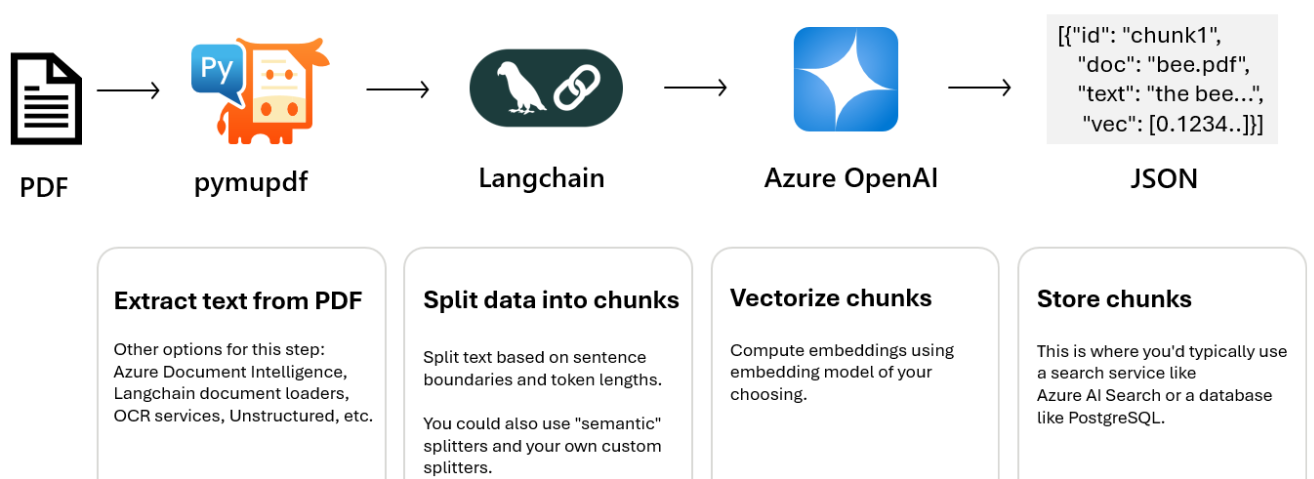

In [ ]:
# Load local embedding model ONCE

# using all-mpnet-base-v2 instead of text-embedding-3-small because of rate limits
embedder = SentenceTransformer("all-mpnet-base-v2") 

def embed(text: str):
    return embedder.encode(text, normalize_embeddings=True).tolist()

def embed_batch(texts):
    return embedder.encode(texts, normalize_embeddings=True).tolist()


In [16]:
DATA_DIR = pathlib.Path.cwd() / "data"

FILENAMES = ["California_carpenter_bee.pdf","Centris_pallida.pdf","Western_honey_bee.pdf","Aphideater_hoverfly.pdf"]

all_chunks = []
for filename in FILENAMES:
    print(f"Processing {filename}")

    # Extract text from the PDF file
    md_text = pymupdf4llm.to_markdown(DATA_DIR / filename)

    # Split the text into smaller chunks
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        model_name="gpt-4o", chunk_size=500, chunk_overlap=125,
    )
    docs = splitter.create_documents([md_text])
    chunks = [{"id": f"{filename}-{i+1}", "text": doc.page_content} for i, doc in enumerate(docs)]

    texts = [c["text"] for c in chunks]
    embeddings = embed_batch(texts)

    for c, e in zip(chunks, embeddings):
        c["embedding"] = e

    all_chunks.extend(chunks)

print(f"Total chunks: {len(all_chunks)}")


Processing California_carpenter_bee.pdf
Processing Centris_pallida.pdf
Processing Western_honey_bee.pdf
Processing Aphideater_hoverfly.pdf
Total chunks: 154


In [22]:
with open("rag_ingested_chunks.json", "w", encoding="utf-8") as f:
    json.dump(all_chunks, f, indent=2)


## RAG Flow 

In [23]:
import os
import openai
from dotenv import load_dotenv

load_dotenv(override=True)
API_HOST = os.getenv("API_HOST", "github")

client = openai.OpenAI(
    base_url="https://models.github.ai/inference",
    api_key=os.environ["GITHUB_TOKEN"],
)

MODEL_NAME = os.getenv("GITHUB_MODEL", "openai/gpt-4o")


In [24]:
# Index the data from the JSON - each object has id, text, and embedding
with open("rag_ingested_chunks.json") as file:
    documents = json.load(file)
    documents_by_id = {doc["id"]: doc for doc in documents}
index = lunr(ref="id", fields=["text"], documents=documents)

# Get the user question
user_question = "where do digger bees live?"

# Search the index for the user question
results = index.search(user_question)
retrieved_documents = [documents_by_id[result["ref"]] for result in results]
print(f"Retrieved {len(retrieved_documents)} matching documents, only sending the first 5.")
context = "\n".join([f"{doc['id']}: {doc['text']}" for doc in retrieved_documents[0:5]])

# Now we can use the matches to generate a response
SYSTEM_MESSAGE = """
You are a helpful assistant that answers questions about insects.
You must use the data set to answer the questions,
you should not provide any info that is not in the provided sources.
Cite the sources you used to answer the question inside square brackets.
The sources are in the format: <id>: <text>.
"""

response = client.chat.completions.create(
    model=MODEL_NAME,
    temperature=0.3,
    messages=[
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": f"{user_question}\nSources: {context}"},
    ],
)

print(f"\nResponse from {MODEL_NAME} on {API_HOST}: \n")
print(response.choices[0].message.content)

Retrieved 109 matching documents, only sending the first 5.

Response from openai/gpt-4o on github: 

Digger bees, specifically _Centris pallida_, live in desert environments in North America. They are solitary bees that dig burrows in the ground, which serve as their nesting sites. These burrows are where females lay their eggs and where males often search for emerging females [Centris_pallida.pdf-1][Centris_pallida.pdf-5].


## RAG Hybrid (keyword + vector search)

**Keyword search** - lunr <br>
**Vector(semantic) similarity search** - cosine similarity(exhaustive search)/HNSW

![Screenshot 2026-01-13 144415.png](<attachment:Screenshot 2026-01-13 144415.png>)
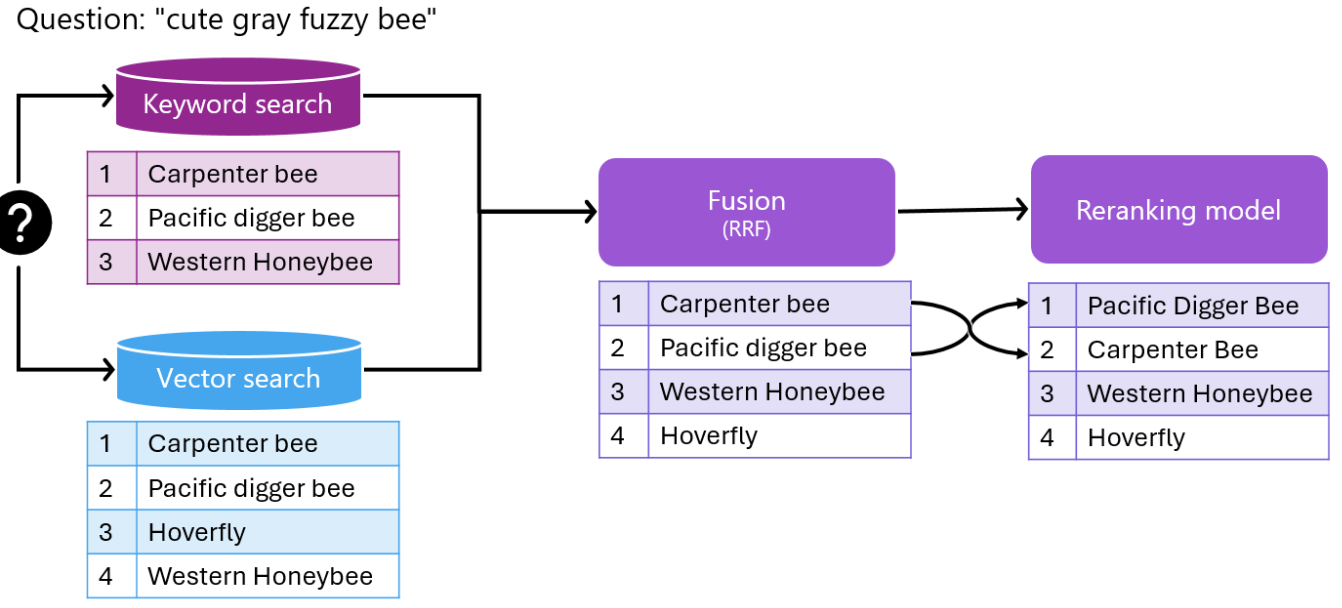

In [25]:
documents = all_chunks
documents_by_id = {d["id"]: d for d in documents}

index = lunr(ref="id",fields=["text"],documents=documents,)


In [26]:
# Perform a full-text search on the indexed documents.
def full_text_search(query, limit):
    results = index.search(query)
    return [documents_by_id[r["ref"]] for r in results[:limit]]

# Perform a vector search on the indexed documents using a simple cosine similarity function.
def cosine_similarity(a, b):
    return sum(x * y for x, y in zip(a, b)) / (
        (sum(x * x for x in a) ** 0.5) * (sum(y * y for y in b) ** 0.5)
    )


def vector_search(query, limit):
    query_embedding = embed(query)  # LOCAL embedding

    similarities = []
    for doc in documents:
        doc_embedding = doc["embedding"]
        similarity = cosine_similarity(query_embedding, doc_embedding)
        similarities.append((doc, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    retrieved_documents = [doc for doc, _ in similarities[:limit]]
    return retrieved_documents



#### Reciprocal Rank Fusion (RRF)

1. Obtain ranked search results from multiple queries executing in parallel.
2. Assign reciprocal rank scores for result in each of the ranked lists. <br>
<t> score = 1/(rank + k) </br>
<t> rank = position of the document in the list, k = constant (perform best if it's set to a small value like 60)

3. Combine scores
4. The engine ranks documents based on combined scores and sorts them.

In [36]:
def reciprocal_rank_fusion(text_results, vector_results, k=60):
    """
    Perform Reciprocal Rank Fusion (RRF) on the results from text and vector searches,
    based on algorithm described here:
    https://learn.microsoft.com/azure/search/hybrid-search-ranking#how-rrf-ranking-works
    """
    scores = {}

    for i, doc in enumerate(text_results):
        if doc["id"] not in scores:
            scores[doc["id"]] = 0
        scores[doc["id"]] += 1 / (i + k)
    for i, doc in enumerate(vector_results):
        if doc["id"] not in scores:
            scores[doc["id"]] = 0
        scores[doc["id"]] += 1 / (i + k)
    scored_documents = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    retrieved_documents = [documents_by_id[doc_id] for doc_id, _ in scored_documents]
    return retrieved_documents


In [37]:
def rerank(query, retrieved_documents):
    """
    Rerank the results using a cross-encoder model.
    """
    encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
    scores = encoder.predict([(query, doc["text"]) for doc in retrieved_documents])
    scored_documents = [v for _, v in sorted(zip(scores, retrieved_documents), reverse=True)]
    return scored_documents



In [38]:
def hybrid_search(query, limit):
    """
    Perform a hybrid search using both full-text and vector search.
    """
    text_results = full_text_search(query, limit * 2)
    vector_results = vector_search(query, limit * 2)
    fused_results = reciprocal_rank_fusion(text_results, vector_results)
    reranked_results = rerank(query, fused_results)
    return reranked_results[:limit]

In [39]:
SYSTEM_MESSAGE = """
You are a helpful assistant that answers questions about insects.
You MUST only use the provided sources.
Cite sources in square brackets [id].
"""

question = "cute gray fuzzy bee"
retrieved = hybrid_search(question, limit=5)

context = "\n".join(f"{d['id']}: {d['text']}" for d in retrieved)

response = client.chat.completions.create(
    model=MODEL_NAME,
    temperature=0.3,
    messages=[
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": f"{question}\n\nSources:\n{context}"},
    ],
)

print(response.choices[0].message.content)


The cute gray fuzzy bee you are describing could be the _Centris pallida_, also known as the digger bee or desert bee. This bee is black and densely covered in gray fur on its dorsal side, with slightly yellowish fur on the thorax. Its legs have a mix of black and reddish fur, and the ventral side is covered in brownish or dark yellow fur. Males tend to have lighter thorax fur and yellowish eyes, while females have more brownish thorax fur and greenish eyes. Both males and females are about 16–17 millimeters in size [3]. 

_Centris pallida_ is native to dry, hot environments in North America, particularly in regions like Arizona, Nevada, and southern California [4].
